## Extract the DHW max value from a specified year

*E. Klein  
2024-04-05*

The Degree-Heating Week (DHW) product is a widely-used indicator of ocean heat gain. Particularly during the summer season, it is used to keep track of the heat stress on coral reefs. 
Although the general seasonal pattern is well-known, the maximum value and the day of the year when it occurs can vary significantly from year to year.

This notebook allows you to connect with the DMS NOAA DHW product, extract the maximum DHW value and the corresponding day of the year for each pixel, and save the results as a netCDF file. 
You have the option to specify a spatial extent and a temporal extent (typically a full year).

In [2]:
## imports
# Loading and manipulating gridded multidimensional data
import xarray as xr
# Accessing S3 buckets
import s3fs
import numpy as np

You need to know the URI of the DHW-zarr product in the DMS. Please visit https://stac.reefdata.io/browser/collections/noaa-crw/items/noaa-crw-chs-dhw and copy the item URI. Below this addrees has been already assigned to te variabl `zarr_path`

In [3]:
## Connect with CRW DHW product
# Path to zarr files
zarr_path = "s3://gbr-dms-data-public/noaa-crw-chs-dhw/data.zarr"

# Connection to public S3 bucket - No credentials needed
fs = s3fs.S3FileSystem(anon=True)

# Loading zarr file
data = xr.open_dataset(s3fs.S3Map(zarr_path, s3=fs), engine="zarr")

# Show data structure
data

<xarray.Dataset> Size: 164GB
Dimensions:              (time: 14254, lat: 900, lon: 1600)
Coordinates:
  * lat                  (lat) float32 4kB -5.025 -5.075 ... -49.92 -49.97
  * lon                  (lon) float32 6kB 100.0 100.1 100.1 ... 179.9 180.0
  * time                 (time) datetime64[ns] 114kB 1985-03-25T12:00:00 ... ...
Data variables:
    crs                  int16 2B ...
    degree_heating_week  (time, lat, lon) float32 82GB ...
    mask                 (time, lat, lon) float32 82GB ...
Attributes: (12/59)
    Conventions:                CF-1.6, ACDD-1.3
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This is a product of the NOAA Coral Reef Watc...
    contributor_name:           NOAA Coral Reef Watch Program
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          20240404T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        20240403T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       24c7f597-298c-4be6-a0c2-ad97b993f60f

Here you can define your data slice:

In [36]:
## Slicing parameters
dateMin = "2024-01-01"
dateMax = "2024-12-31"
latMin = -26.0
latMax = -8.5
lonMin = 140.0
lonMax = 160.0


With these values, extract the data you need

In [31]:
## get data

DHWyear = data.sel(time=slice(dateMin, dateMax)).degree_heating_week

# Clip region. Note that lat is sorted in reverse order
DHWyear = DHWyear.sel(lat= slice(latMax, latMin), lon = slice(lonMin, lonMax))
DHWyear


<xarray.DataArray 'degree_heating_week' (time: 365, lat: 350, lon: 400)> Size: 204MB
[51100000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 1kB -8.525 -8.575 -8.625 ... -25.88 -25.92 -25.98
  * lon      (lon) float32 2kB 140.0 140.1 140.1 140.2 ... 159.9 159.9 160.0
  * time     (time) datetime64[ns] 3kB 2023-01-01T12:00:00 ... 2023-12-31T12:...
Attributes:
    coverage_content_type:  physicalMeasurement
    grid_mapping:           crs
    long_name:              degree heating week
    standard_name:          N/A
    units:                  degree_Celsius_weeks
    valid_max:              10000
    valid_min:              0

Now, you can extract the maximum value of the DHW for each of the pixels

In [32]:
## Get max values
## coords
lat = DHWyear.lat
lon = DHWyear.lon
## max value
DHWmax = DHWyear.max(dim='time')
DHWmax.attrs = DHWyear.attrs

This is the plot of the DHWmax for the seleted area/time

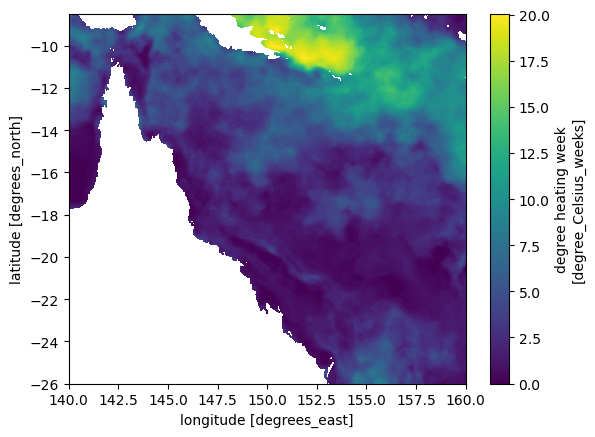

In [33]:
DHWmax.plot()

and the day of the year when it reaches the maximun value:  
Note that because the argmax function produce an error when find a full vector of no data, we need to transform the data to eliminate those NaNs

In [34]:
## day of max value
## need a trick to avoid all NaN slice error in argmax method
mask = np.isnan(DHWmax)
DHWzero = DHWyear.fillna(0)
DHWyday = DHWzero.argmax(dim='time') + 1
DHWyday = np.ma.array(DHWyday.astype('float').values, mask=mask)
DHWyday = DHWyday.filled(np.nan)
DHWyday = xr.DataArray(DHWyday, coords=[lat, lon], dims=['lat', 'lon'],
                       attrs={'long_name': "day of the year where DHWmax"})

This is the plot of the day of the year when the DHWmax was reached:

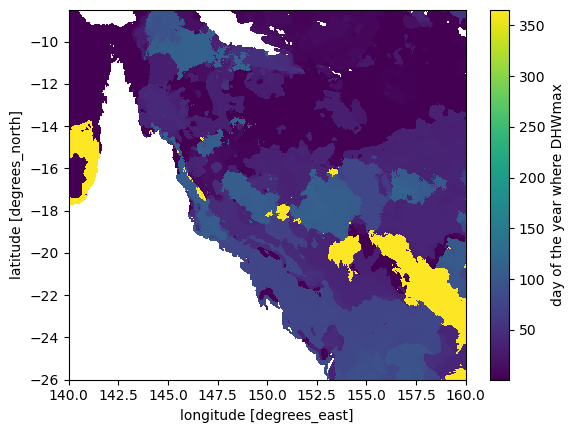

In [35]:
DHWyday.plot()

Now, with the two data arrays, create a dataset and add some global attributes. Remember add your name and email if desired.

In [37]:

## edit some attrs
globAttrs = {}
globAttrs['title'] = "DHWmax and time of the year when DHW max was reached"
globAttrs['creator_name'] = "YOUR NAME"
globAttrs['creator_email'] = "YOUR EMAIL"
globAttrs['comment'] = "Data extracted from the GBR Data Management System https://stac.reefdata.io/browser"

globAttrs['geospatial_lat_max'] = latMax
globAttrs['geospatial_lat_min'] = latMin
globAttrs['geospatial_lon_max'] = lonMax
globAttrs['geospatial_lon_min'] = lonMin
globAttrs['geospatial_lat_resolution'] = 0.05
globAttrs['geospatial_lon_resolution]'] = 0.05

globAttrs['time_coverage_start'] = dateMin
globAttrs['time_coverage_end'] = dateMax



In [27]:
## Create DHWmax dataset
DHW_max = xr.Dataset({'DHWmax': DHWmax, 'DHWyday': DHWyday})
DHW_max.attrs= globAttrs

DHW_max

<xarray.Dataset> Size: 2MB
Dimensions:  (lat: 350, lon: 400)
Coordinates:
  * lat      (lat) float32 1kB -8.525 -8.575 -8.625 ... -25.88 -25.92 -25.98
  * lon      (lon) float32 2kB 140.0 140.1 140.1 140.2 ... 159.9 159.9 160.0
Data variables:
    DHWmax   (lat, lon) float32 560kB 7.32 6.44 5.61 4.94 ... 13.82 13.55 13.38
    DHWyday  (lat, lon) float64 1MB 68.0 68.0 68.0 68.0 ... 68.0 68.0 68.0 68.0
Attributes:
    title:                       DHWmax and time of the year when DHW max was...
    creator_name:                YOUR NAME
    creator_email:               YOUR EMAIL
    comment:                     Data extracted from the GBR Data Management ...
    geospatial_lat_max:          -8.5
    geospatial_lat_min:          -26.0
    geospatial_lon_max:          160.0
    geospatial_lon_min:          140.0
    geospatial_lat_resolution:   0.05
    geospatial_lon_resolution]:  0.05
    time_coverage_start:         2024-01-01
    time_coverage_end:           2024-12-31

Write the results into a local file

In [ ]:

## write results
DHW_max.to_netcdf("DHWmax_y2date.nc")


Done!